# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import re
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
sample = np.array(df.groupby('email')['article_id'].count())
print('Mean: {}'.format(sample.mean()))
print('Standard deviation: {}'.format(sample.std()))
print('Min: {}'.format(sample.min()))
print('Max: {}'.format(sample.max()))

Mean: 8.930846930846931
Standard deviation: 16.8006351254692
Min: 1
Max: 364


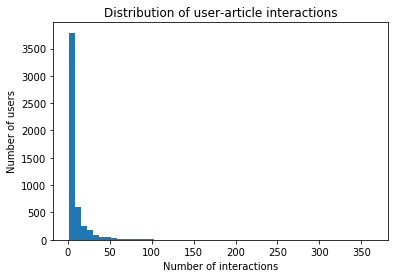

In [4]:
plt.hist(sample, bins=50)
plt.title('Distribution of user-article interactions')
plt.xlabel('Number of interactions')
plt.ylabel('Number of users');

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.percentile(sample, 50)
max_views_by_user = sample.max()

print('50% of individuals interact with {} number of articles or fewer.'.format(int(median_val)))
print('The maximum number of user-article interactions by any 1 user is {}.'.format(int(max_views_by_user)))

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
print('Dataset registers: {}'.format(df_content.shape[0]))
print('Number of unique articles in dataset: {}'.format(df_content['article_id'].nunique()))

Dataset registers: 1056
Number of unique articles in dataset: 1051


In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)
df_content.shape[0]

1051

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
unique_articles = df['article_id'].nunique()
total_articles = df_content['article_id'].nunique()
unique_users = df['email'].nunique()
user_article_interactions = df.shape[0]

print('The number of unique articles that have at least one interaction: {}'.format(unique_articles))
print('The number of unique articles on the IBM platform: {}'.format(total_articles))
print('The number of unique users: {}'.format(unique_users))
print('The number of user-article interactions: {}'.format(user_article_interactions))

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
views_by_article = df['article_id'].value_counts().reset_index()
most_viewed_article_id = str(views_by_article.loc[0]['index'])
max_views = int(views_by_article.loc[0]['article_id'])

print('The most viewed article id was {} with {} views'.format(most_viewed_article_id, max_views))

The most viewed article id was 1429.0 with 937 views


In [10]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [12]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    interactions_by_article = df.groupby('title')['user_id'].count().reset_index()
    interactions_by_article.sort_values('user_id', ascending=False, inplace=True)
    top_articles = list(interactions_by_article.iloc[:n]['title'])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    interactions_by_article = df.groupby('article_id')['user_id'].count().reset_index()
    interactions_by_article.sort_values('user_id', ascending=False, inplace=True)
    top_articles = list(interactions_by_article.iloc[:n]['article_id'])
 
    return top_articles # Return the top article ids 

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [14]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [15]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['user_id'].count().unstack()
    user_item[user_item > 0] = 1
    user_item.fillna(0, inplace = True)
    user_item.head()
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [16]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.query('user_id == @user_id').T).rename(columns={user_id: 'sim'})
    
    # sort by similarity
    similarity.sort_values(by='sim', ascending=False, inplace=True)
    
    # create list of just the ids
    most_similar_users = list(similarity.index)
       
    # remove the own user's id    
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    all_articles = user_item.loc[user_id]
    article_ids = [str(art) for art, value in all_articles.items() if value > 0]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    seen_art_ids, _ = get_user_articles(user_id)
    recs = set()
    
    for sim_user in similar_users:
        if (len(recs) > m):
            break
            
        art_ids, _ = get_user_articles(sim_user)
        art_rec = np.setdiff1d(art_ids, seen_art_ids)
        
        recs.update(art_rec)
    
    return list(recs)[:m] # return your recommendations for this user_id    

In [20]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['ml optimization using cognitive assistant',
 'analyze open data sets with spark & pixiedust',
 '502    forgetting the past to learn the future: long ...\nName: title, dtype: object',
 'awesome deep learning papers',
 'this week in data science (february 14, 2017)',
 'flightpredict ii: the sequel  – ibm watson data lab',
 'using machine learning to predict parking difficulty',
 'this week in data science (may 2, 2017)',
 'get started with streams designer by following this roadmap',
 'analyze facebook data using ibm watson and watson studio']

In [21]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [22]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''     
    # compute similarity of each user to the provided user    
    similarities = list(user_item.dot(user_item.query('user_id == @user_id').T).values.flatten())

    # compute the total interactions for each user
    num_interactions = list(df.groupby('user_id')['article_id'].count())

    # get the user_id for each neighbor
    neighbor_id = list(user_item.index)

    # create the dataframe with the collected data
    neighbors_df = pd.DataFrame({'similarity': similarities,
                                'num_interactions': num_interactions}, index=neighbor_id)    

    # rename index for neighbor_id
    neighbors_df.index.rename('neighbor_id', inplace=True)
    
    # sort by similarity
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    # remove the user_id from neighbors
    neighbors_df.drop(user_id, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions.
   
    '''
    neighbors_users = get_top_sorted_users(user_id)
    seen_art_ids, _ = get_user_articles(user_id)
    
    total_interactions = user_item.sum().values.tolist()
    articles_ids = user_item.columns.values.tolist()

    interactions = pd.DataFrame({'n_interactions': total_interactions}, index=articles_ids)
    interactions.sort_values('n_interactions', ascending=False, inplace=True)

    recs = set()
    
    for neighbor_user in neighbors_users.index.tolist():
        if (len(recs) > m):
            break
            
        art_ids, _ = get_user_articles(neighbor_user)
        art_rec = np.setdiff1d(art_ids, seen_art_ids)
        
        ranked_articles = interactions[interactions.index.isin(art_rec)].index.tolist()
        recs.update(ranked_articles)
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [23]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
{1024.0, 1409.0, 1410.0, 1411.0, 1152.0, 1157.0, 1154.0, 1153.0, 1160.0, 1162.0, 1163.0, 12.0, 1420.0, 1166.0, 651.0, 1296.0, 1424.0, 1170.0, 1427.0, 1172.0, 1426.0, 911.0, 142.0, 1304.0, 1176.0, 1433.0, 793.0, 1150.0, 1151.0, 164.0, 1444.0, 681.0, 939.0, 1324.0, 555.0, 302.0, 686.0, 1329.0, 1330.0, 1331.0, 1335.0, 1336.0, 1338.0, 1085.0, 1346.0, 1351.0, 1354.0, 1356.0, 1357.0, 205.0, 1360.0, 336.0, 465.0, 1364.0, 981.0, 1367.0, 1368.0, 730.0, 1386.0, 362.0, 109.0, 1391.0, 880.0, 1396.0, 761.0, 1276.0, 125.0, 1278.0, 1407.0}

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'ibm

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [24]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).index.tolist()[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).index.tolist()[9]# Find the 10th most similar user to user 131

In [25]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, it's better to use the function to return the top article based on the number of interactions (get_top_articles or get_top_articles_ids) since we don't have any data about the user's interactions with articles to use the content based recommendations.

The functions were written to give recommendations based on similarities between users!  How the user doesn't exist in the dataset, this action will raise an error. Even if the user was inserted in the dataset with zeros for all interactions between the articles, the dot product between this user and the others will be zero, which means no recommendations.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [26]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(i) for i in get_top_article_ids(10)]

In [27]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.

In [28]:
def tokenize(text):
    """
    INPUT:
    text - a string with an english text
    
    OUTPUT:
    clean_tokens - a list with the clean tokens based on the english text
    """
    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    
    tokens = word_tokenize(text)
    stop_words = stopwords.words("english")
    tokens = [word for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


def create_token_matrix(df_content=df_content, tokenizer=tokenize):
    '''
    INPUT:
    df_content - the dataframe with each article details documented
    tokenizer - the function to tokenizer each description of text
    
    OUTPUT:
    tokenize_matrix - a matrix where each row is a article and
    each column is a token which can be represented in the article 
    description or not
    
    '''
    
    df_content.dropna(subset=['doc_description'], inplace=True)
    
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer())
    ])
    
    tokenize_matrix = pipeline.fit_transform(df_content.doc_description)
    
    return tokenize_matrix


article_tokens = create_token_matrix()

In [29]:
def make_content_recs(article_id, m=10, df_content=df_content, article_tokens=article_tokens):
    '''
    INPUT:
    article_id - the article_id which we are interesting in finding similar articles 
    m - the number of similar articles we are interesting
    df_content -the dataframe with each article details documented
    article_tokens - the tokenize matrix obtained from the function create_token_matrix
    
    OUTPUT:
    recs - content based recommendation where is it possible, otherwise we get the top
    recommendations
    
    '''
    recs = []
    article_id = int(article_id)
    
    # checking if the article_id is documented on df_content
    if article_id in df_content.article_id.tolist():
        article_idx = np.where(df_content.article_id == article_id)[0][0]
        
        # calculating similarity between the article_id and the all others articles
        similarity = cosine_similarity(article_tokens[article_idx], article_tokens)[0]
        
        # sort by descending similarities to get the most m similar articles
        df_similarity = pd.DataFrame({'cos_sim': similarity})
        df_similarity.sort_values('cos_sim', ascending=False, inplace=True)

        # remove the own article_id from the list
        df_similarity.drop(article_id, inplace=True)
        recs = list(df_similarity.head(m).index)
    
    else:
        recs = get_top_article_ids(m)
    
    
    return recs    

The content based recommendation uses the article description to build a corpus of tokens using TF-IDF representation to create this way a matrix with all possible tokens inserted in the article description. Using the cosine similarity applied to this matrix, we find the similarities with all articles from a specific article in particular. For articles not inserted in the dataset, i.e new articles, we use the top-ranked articles to make recommendations.

A possible improvement would be to use the document body to get the tokens and then create a TF-IDF representation. Another improvement would be to use the number of interactions as a tiebreaker, when cosine similarity encounter the same similarity for 2 articles. 

In [30]:
# make recommendations for a brand new user
new_user_recs = get_top_article_ids(10)

# make a recommendations for a user who only has interacted with article id '1427.0'
recs_for_art_1427 = make_content_recs(1427.0)

recs_for_art_1000 = make_content_recs(1000.0)

print('Recomendations to new users: {}'.format(new_user_recs))
print('Recomendations for user who only has interacted with article 1427: {}'.format(recs_for_art_1427))
print('Recomendations for user who only has interacted with article 1000: {}'.format(recs_for_art_1000))

Recomendations to new users: [1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]
Recomendations for user who only has interacted with article 1427: [1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]
Recomendations for user who only has interacted with article 1000: [997, 786, 606, 1037, 371, 767, 829, 864, 296, 91]


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [31]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [32]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [33]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

Different from the lesson, all missing values were filled with 0’s, so the built-in function will not raise error. For the lack of interaction with an article, we have to suppose the user does not like an article instead of just not interacting with them.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

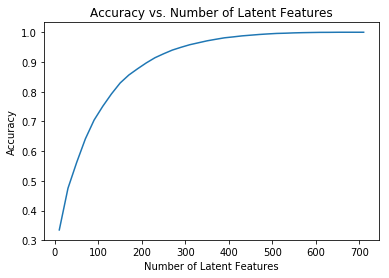

In [34]:
num_latent_feats = np.arange(10,720+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [35]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test.user_id.unique().tolist()
    test_arts = df_test.article_id.unique().tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [36]:
# How many users can we make predictions for in the test set?
np.intersect1d(test_idx, df_train.user_id).size

20

In [37]:
# How many users are we not able to make predictions for because of the cold start problem?
np.setdiff1d(test_idx, df_train.user_id).size

662

In [38]:
# How many articles can we make predictions for in the test set?
np.intersect1d(test_arts, df_train.article_id).size

574

In [39]:
# How many articles are we not able to make predictions for because of the cold start problem?
np.setdiff1d(test_arts, df_train.article_id).size

0

In [40]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [41]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [42]:
user_row = user_item_train.index.isin(test_idx)
articles_col = user_item_train.columns.isin(test_arts)

u_test = u_train[user_row, :]
vt_test = vt_train[:, articles_col]

users_idx = np.intersect1d(test_idx, df_train.user_id)
articles_idx = np.intersect1d(test_arts, df_train.article_id)
user_item_test = user_item_test.loc[user_item_test.index.isin(users_idx), user_item_test.columns.isin(articles_idx)]

In [43]:
np.sum(user_item_train.sum())

29264.0

In [44]:
user_item_train.shape[0]*user_item_train.shape[1]

3203718

In [45]:
np.sum(user_item_train.sum())/(user_item_train.shape[0]*user_item_train.shape[1])

0.0091343869841228227

In [46]:
np.sum(user_item_test.sum())/(user_item_test.shape[0]*user_item_test.shape[1])

0.018989547038327528

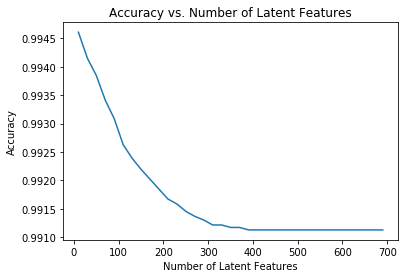

In [47]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [48]:
interactions = np.sum(user_item_test.sum())
print('Total interactions in test set: {}'.format(interactions))
print('Total possibilities in test set: {}'.format(user_item_test.shape[0]*user_item_test.shape[1]))

Total interactions in test set: 218.0
Total possibilities in test set: 11480


Accuracy, in this case, is not a good measure to test how well the model is predicting, since our classes are imbalanced. Our test set has 20 x 574 possibilities of interactions, i.e 11.480, of which just 218 are real interactions.

Another method to evaluate the model would be using an online approach through A/B-testing for example. In this case, we have our control group handling the system without the new recommendation system and the experiment group will receive access to the feature with a new recommendation system. We can use the userIDs to separate the groups in the experiment, since just users with account in the system have access to the articles. We could use as a metric, the number of article interactions in a time frame to understand if the interactions increase for the experiment group. The time frame should be considering the flow in the system on weekends and special dates.

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0